<a href="https://colab.research.google.com/github/AliRizvi14/CE888/blob/master/lab7/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CE888 Lab 7
Dr Ana Matran-Fernandez,  University of Essex.

## Training a CNN Classifier

- Lab Objective: Create, train, and test a CNN model

### Instructions: 

1. Go through each code block,
 study and make sure you understand each of them,
 and fill in the missing "TODO" parts.

2. Save a neural network for the MNIST dataset and run it as an attachment through the Moodle CE888 Lab 7 quiz.

3. Save a neural network for the Cifar10 dataset and run it as an attachment through the Moodle CE888 Lab 7 quiz.

4. If you have time, work through the "checklist of things to do" in the final block of this page.

Before you start (if you're running this locally; this is not necessary on Colab):
- Check you have the python packages numpy, matplotlib, tensorflow.
- e.g., install them with "pip3 install numpy, matplotlib, tensorflow"
- IMPORTANT!!!!! If you're doing the lab on Colab, make sure you've changed your runtime to GPU. This will significantly reduce the training time of the networks (this should take seconds if you're on GPU).

Acknowledgements:
- This lab session is based on Dr Michael Fairbank's CE811 materials.

In [3]:
# Imports
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

## Load a vision benchmark dataset

- We will start with the MNIST hand-written numeric digits dataset.


In [62]:
dataset_name = "cifar10"

if dataset_name == "cifar10":
    dataset = tf.keras.datasets.cifar10
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']
    # CIFAR10 images are 32*32*3.
    accuracy_threshold = 0.6  # Moodle progress checker expects >60% accuracy on CIFAR10
elif dataset_name == "fashion":
    dataset = tf.keras.datasets.fashion_mnist
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat','Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
    accuracy_threshold = 0.8
elif dataset_name == "mnist":
    accuracy_threshold = 0.96  # Moodle progress checker expects >96% accuracy on MNIST.
    dataset = tf.keras.datasets.mnist
    class_names = ['zero', 'one', 'two', 'three', 'four','five', 'six', 'seven', 'eight', 'nine']
else:
    print("unknown dataset")
    raise Exception("Please specify a valid dataset!")

(train_images0, train_labels0), (test_images0, test_labels0) = dataset.load_data()

print('Train: X=%s, y=%s' % (train_images0.shape, train_labels0.shape))
print('Test: X=%s, y=%s' % (test_images0.shape, test_labels0.shape))

train_labels = train_labels0.reshape(-1)
test_labels = test_labels0.reshape(-1)


Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


(array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

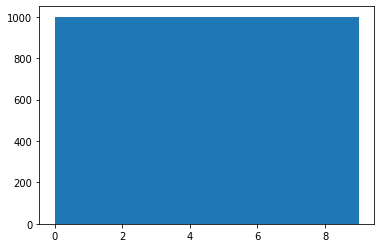

In [63]:
plt.hist(test_labels)

(array([5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000., 5000.,
        5000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

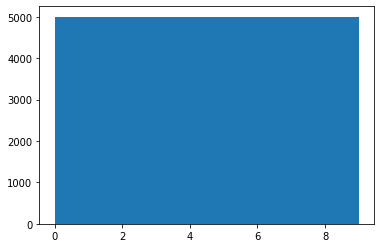

In [64]:
plt.hist(train_labels)

## Visualise the Dataset

- Show a few pictures of the images we are trying to learn from...

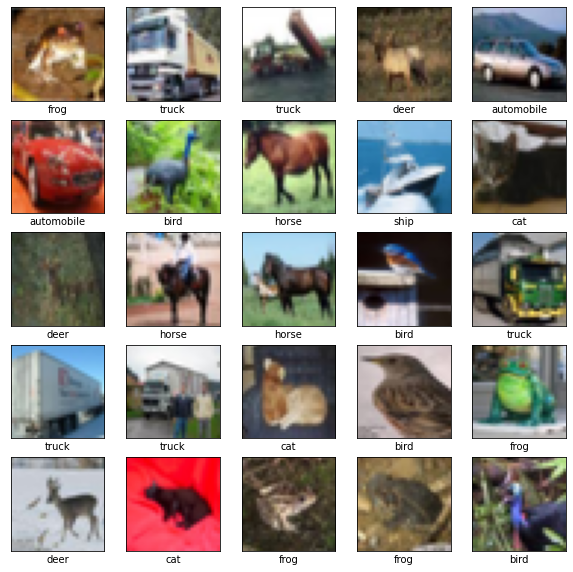

In [66]:
# plot a few images
plt.figure(figsize=(10,10))
for i in range(25):
    # define subplot
    plt.subplot(5,5,i+1)
    # plot raw pixel data
    plt.imshow(train_images0[i], cmap=plt.get_cmap('gray'))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if class_names != None:
        # Add a label underneath, if we have one...
        plt.xlabel(class_names[train_labels[i]])
plt.show()

## Prep the data
- The keras datasets contain integer pixel intensities from 0 to 255.  We must rescale this to floats from 0 to 1.

In [67]:
# Rescale greyscale from 8 bit to floating point (by dividing by 255)
test_images = (test_images0 / 255.0).astype(np.float32) # 10000 test patterns, shape 10000*28*28  
train_images = (train_images0 / 255.0).astype(np.float32) # 60000 train patterns, shape 60000*28*28

if len(train_images.shape) == 3:  # images must be rank-4 tensors [number_of_images, dimension1, dimension2, number_of_channels]
    # add a single channel to these black-and-white images
    train_images=train_images.reshape(list(train_images.shape)+[1])
    test_images=test_images.reshape(list(test_images.shape)+[1])
    print("Reshaped images from ", train_images0.shape, "to", train_images.shape, "so that 'channel' dimension exists")

num_classification_categories = train_labels.max() + 1


## Define a model
- We'll bulid our neural network here.
- TO DO: Modify the simple model defined below
 so that it has the following structure.
- Use relu activation functions everywhere,
 except for the last layer which must have a softmax activation function.
- Use kernel size (3, 3) for each convolutional layer
 and pool size (2, 2) for each max-pooling layer.
- Ensure you obtain the architecture exactly as shown here...

```
_________________________________________________________________
Layer (type)                 Output Shape              Param #
=================================================================
layer1 (Conv2D)              (None, 28, 28, 6)         60
_________________________________________________________________
layer2 (MaxPooling2D)        (None, 14, 14, 6)         0
_________________________________________________________________
layer3 (Conv2D)              (None, 14, 14, 3)         165
_________________________________________________________________
layer4 (MaxPooling2D)        (None, 7, 7, 3)           0
_________________________________________________________________
layer5 (Flatten)             (None, 147)               0
_________________________________________________________________
layer6 (Dense)               (None, 128)               18944
_________________________________________________________________
layer7 (Dense)               (None, 10)                1290
=================================================================
Total params: 20,459
Trainable params: 20,459
Non-trainable params: 0
_________________________________________________________________

```


In [80]:
# build model with CNN architecture
model = keras.Sequential()

# YOUR CODE HERE (do not specify the input shape in the first layer)



model.add(layers.Conv2D(16, 3, activation='relu',padding="same"))
model.add(layers.Conv2D(32, 3, activation='relu',padding="same"))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(layers.Dropout(0.5))




model.add(layers.Conv2D(64, 3, activation='relu',padding="same"))
model.add(layers.Conv2D(64, 3, activation='relu',padding="same"))
model.add(layers.MaxPooling2D(pool_size=2))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classification_categories, activation='softmax'))


## View Model Summary

- Have a look at the model summary here and compare with the output above to make sure they're the same.

In [87]:
model.build(input_shape=(None,) + train_images.shape[1:])
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 conv2d_39 (Conv2D)          (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_40 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_41 (Conv2D)          (None, 16, 16, 64)        36928     
                                                     

In [83]:
if model.count_params() > 800000 and dataset_name == "cifar10":
    print("The lab7 quiz has a 10MB limit on your model size, so use a smaller model if you want to validate through the auto-marker!")

## Train the network

In [84]:
optimizer = keras.optimizers.Adam()

model.compile(optimizer=optimizer,  
              loss=keras.losses.SparseCategoricalCrossentropy(), 
              metrics=['accuracy'])

history = model.fit(train_images, train_labels,
                batch_size=128,
                epochs=5,
                validation_data=(test_images, test_labels))


Epoch 1/5
391/391 [==============================] - 5s 12ms/step - loss: 0.8582 - accuracy: 0.6970 - val_loss: 0.7874 - val_accuracy: 0.7227
Epoch 2/5
391/391 [==============================] - 4s 11ms/step - loss: 0.8042 - accuracy: 0.7176 - val_loss: 0.7302 - val_accuracy: 0.7442
Epoch 3/5
391/391 [==============================] - 4s 10ms/step - loss: 0.7666 - accuracy: 0.7298 - val_loss: 0.7583 - val_accuracy: 0.7362
Epoch 4/5
391/391 [==============================] - 4s 10ms/step - loss: 0.7333 - accuracy: 0.7403 - val_loss: 0.6939 - val_accuracy: 0.7556
Epoch 5/5
391/391 [==============================] - 4s 11ms/step - loss: 0.6964 - accuracy: 0.7528 - val_loss: 0.6708 - val_accuracy: 0.7643


## Plot graphs of learning progress...

- Have a look at these graphs, and try to work out whether any
 overfitting has occurred, or whether we would gain any benefit
 from training for more or fewer epochs (TODO)

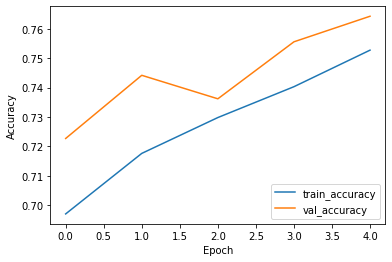

In [85]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

## Inspect how well the system is working...
- The test set has a lot of images in it,
 but we can only view 25 at a time.
- You can rerun the next code block several times,
 to get a different random set of samples from the test set (TODO)


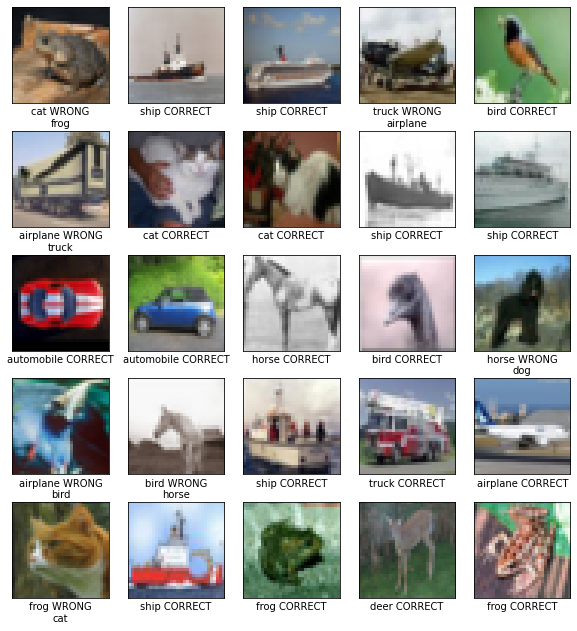

In [86]:
plt.figure(figsize=(10,11))
# plot 25 random images from the test set.
first_index = np.random.randint(len(test_images)-25)
for i in range(first_index,first_index+25):
    # define subplot
    plt.subplot(5,5,i+1-first_index)
    # plot raw pixel data
    plt.imshow(test_images0[i], cmap=plt.get_cmap('gray'))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if class_names != None:
        # Add a label underneath, if we have one...
        prediction = model(test_images[i:i+1])[0,:]
        prediction_class = np.argmax(prediction)
        true_label = test_labels[i]
        class_name = class_names[prediction_class]
        plt.xlabel(class_name+" "+("CORRECT" if prediction_class==true_label else "WRONG\n{}".format(class_names[true_label])))
plt.subplots_adjust(hspace=0.2)
plt.show()

## Save the model
- Once you have the correct layers created (as described above)
 and have trained a model which can score >96% on the
 MNIST digits validation set, save your model with the next code block.
- Then use your saved model as an attachment to pass questions 1+2 of
 the Lab 7 Quiz on Moodle.

In [88]:
if history.history["val_accuracy"][-1] > accuracy_threshold:
    print("Your model is accurate enough!")
    # Save the model into a local folder
    keras.models.save_model(model, "Model1"+dataset_name+".h5",save_format='h5')
else:
    print("Accuracy is below the threshold!")
    raise Exception("Your model isn't accurate enough to pass the progress checker!")

Your model is accurate enough!


# CIFAR10 image set

- Repeat all of the steps above, but change the dataset_name in the
 top code-block to "cifar10"
- We need a bigger network for CIFAR10 than we did for MNIST.
 Use this architecture:

```
_________________________________________________________________
Layer (type)                 Output Shape              Param #
=================================================================
layer1 (Conv2D)              (None, 32, 32, 16)        448
_________________________________________________________________
layer2 (Conv2D)              (None, 32, 32, 32)        4640
_________________________________________________________________
layer3 (MaxPooling2D)        (None, 16, 16, 32)        0
_________________________________________________________________
layer4 (Dropout)             (None, 16, 16, 32)        0
_________________________________________________________________
layer5 (Conv2D)              (None, 16, 16, 64)        18496
_________________________________________________________________
layer6 (Conv2D)              (None, 16, 16, 64)        36928
_________________________________________________________________
layer7 (MaxPooling2D)        (None, 8, 8, 64)          0
_________________________________________________________________
layer8 (Dropout)             (None, 8, 8, 64)          0
_________________________________________________________________
layer9 (Flatten)             (None, 4096)              0
_________________________________________________________________
layer10 (Dense)              (None, 128)               524416
_________________________________________________________________
layer11 (Dense)              (None, 10)                1290
=================================================================
Total params: 586,218
Trainable params: 586,218
Non-trainable params: 0
_________________________________________________________________
```

- For the dropout layers, use a Dropout rate of 0.2
- Train for at least 5 epochs,
 and you should be able to score >60% on the test set for CIFAR10.
- Note that the above architecture is still pretty small
 (particularly, by only having 64 filters).
 But we need this particular smaller architecture,
 so that the auto-marker can handle it comfortably.

Once you have this working, upload your saved model to questions 3+4 of the progress checker.

## Checklist of further things to do

Okay you should have completed the progress checker by now.
But if you want to explore further, then...

1. Check you have made 2 different convolutional neural network classifiers, one for MNIST and one for Cifar10.

2. Check that in each case you have inspected the results,
 the validation accuracy and decided whether more or fewer epochs
 would be beneficial.

3. If you have time remaining then see if you can improve performance
 on Cifar10.
    * Possible methods:
        * Try training for longer.
        * Add more convolutional layers.
        * Add more filters at each convolutional layer.
    * Have a look at the CNN structure used here (https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/) to see how you could score >80% on CIFAR10 (see the final architecture at the bottom of the page). However, this requires a lot of CPU/GPU time.

4. If time permits, then see what the effect of changing the relu activation functions to tanh.

